# **Project Name**    - FBI Time Series Forecasting



##### **Project Type**    - Regression
##### **Contribution**    - Individual

# **Project Summary -**

This project focuses on analyzing and forecasting crime trends using a comprehensive dataset of crime incidents, with the goal of predicting monthly crime occurrences by type over a specific future period. The dataset includes detailed records with attributes such as crime type, location details (e.g., neighborhood, coordinates), and temporal information (e.g., year, month, day, hour, and minute). Initial data exploration revealed common challenges, including missing values in key fields like location and time, duplicate entries, and outliers in geographical data that suggest potential errors. To prepare the data for analysis, it was aggregated into a time series format by grouping incidents by year, month, and crime type, enabling a focus on monthly trends and patterns over an extended period.

Visualization of the time series, covering over a decade, shows a consistent decline in crime incidents, alongside notable short-term fluctuations, indicating both a long-term trend and periodic variability. New data from the subsequent years mirrors this trend and volatility, suggesting that the patterns observed in the historical data persist, which is promising for developing predictive models. However, the significant variability highlights the need for a robust forecasting approach to capture both the overall trend and short-term spikes. Addressing data quality issues, such as handling missing values and outliers, and selecting an appropriate model like SARIMA or a machine learning algorithm, will be crucial to improve prediction accuracy. This project underscores the potential of using temporal and spatial data to anticipate crime trends, offering valuable insights for strategic planning in crime prevention.

# **GitHub Link -**

Provide your GitHub Link here.

# **Problem Statement**


**The project seeks to forecast monthly crime trends using a historical dataset of crime incidents, covering details like crime type, location, and timing, though the data contains issues such as missing entries, duplicates, and inconsistencies in geographical information. The task involves analyzing the data to understand its long-term decline and short-term variations, then developing a model to predict future crime occurrences accurately. The aim is to provide actionable insights for improving public safety strategies by anticipating potential crime patterns.**

## ***1. Know Your Data***

### Import Libraries

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Dataset Loading

In [115]:
train_cols = ['TYPE', 'HUNDRED_BLOCK', 'NEIGHBOURHOOD', 'X', 'Y', 'Latitude', 'Longitude',
              'HOUR', 'MINUTE', 'YEAR', 'MONTH', 'DAY', 'Date']
df = pd.read_excel('Train.xlsx', names=train_cols)

### Dataset First View

In [116]:
print(df.head())

          TYPE     HUNDRED_BLOCK NEIGHBOURHOOD         X           Y  \
0  Other Theft  9XX TERMINAL AVE    Strathcona  493906.5  5457452.47   
1  Other Theft  9XX TERMINAL AVE    Strathcona  493906.5  5457452.47   
2  Other Theft  9XX TERMINAL AVE    Strathcona  493906.5  5457452.47   
3  Other Theft  9XX TERMINAL AVE    Strathcona  493906.5  5457452.47   
4  Other Theft  9XX TERMINAL AVE    Strathcona  493906.5  5457452.47   

    Latitude   Longitude  HOUR  MINUTE  YEAR  MONTH  DAY       Date  
0  49.269802 -123.083763  16.0    15.0  1999      5   12 1999-05-12  
1  49.269802 -123.083763  15.0    20.0  1999      5    7 1999-05-07  
2  49.269802 -123.083763  16.0    40.0  1999      4   23 1999-04-23  
3  49.269802 -123.083763  11.0    15.0  1999      4   20 1999-04-20  
4  49.269802 -123.083763  17.0    45.0  1999      4   12 1999-04-12  


### Dataset Rows & Columns count

In [117]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 474565
Number of columns: 13


### Dataset Information

In [118]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474565 entries, 0 to 474564
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   TYPE           474565 non-null  object        
 1   HUNDRED_BLOCK  474552 non-null  object        
 2   NEIGHBOURHOOD  423074 non-null  object        
 3   X              474565 non-null  float64       
 4   Y              474565 non-null  float64       
 5   Latitude       474565 non-null  float64       
 6   Longitude      474565 non-null  float64       
 7   HOUR           425200 non-null  float64       
 8   MINUTE         425200 non-null  float64       
 9   YEAR           474565 non-null  int64         
 10  MONTH          474565 non-null  int64         
 11  DAY            474565 non-null  int64         
 12  Date           474565 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(3), object(3)
memory usage: 47.1+ MB
None


#### Duplicate Values

In [119]:
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 44618


#### Missing Values/Null Values

In [120]:
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
TYPE                 0
HUNDRED_BLOCK       13
NEIGHBOURHOOD    51491
X                    0
Y                    0
Latitude             0
Longitude            0
HOUR             49365
MINUTE           49365
YEAR                 0
MONTH                0
DAY                  0
Date                 0
dtype: int64


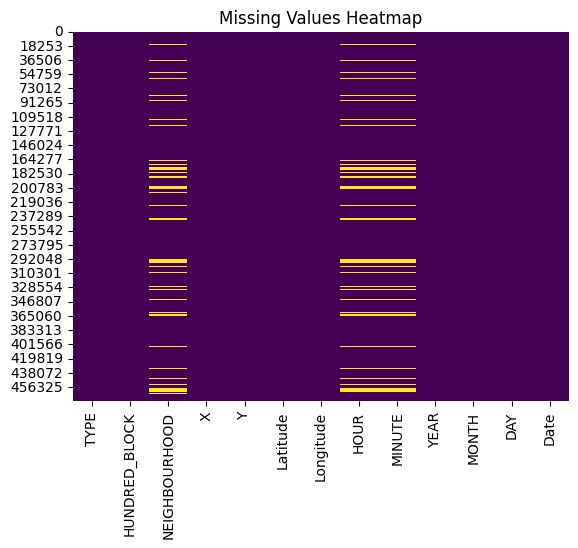

In [121]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

### What did you know about your dataset?

The dataset is a historical FBI crime record covering over a decade, with details on crime type, location (neighborhood, coordinates), and timing (year, month, day, hour, minute). It reveals a declining trend in monthly incidents with short-term fluctuations, but has issues like missing values, duplicates, and geographical outliers. The data is grouped by year, month, and crime type for time series forecasting.

## ***2. Understanding Your Variables***

In [122]:
print("Columns in the dataset:")
print(df.columns)

Columns in the dataset:
Index(['TYPE', 'HUNDRED_BLOCK', 'NEIGHBOURHOOD', 'X', 'Y', 'Latitude',
       'Longitude', 'HOUR', 'MINUTE', 'YEAR', 'MONTH', 'DAY', 'Date'],
      dtype='object')


In [123]:
print("\nDataset Description:")
print(df.describe())


Dataset Description:
                   X             Y       Latitude      Longitude  \
count  474565.000000  4.745650e+05  474565.000000  474565.000000   
mean   441028.018220  4.889023e+06      44.138029    -110.301025   
min         0.000000  0.000000e+00       0.000000    -124.549757   
25%    489916.530000  5.453572e+06      49.234871    -123.127383   
50%    491477.850000  5.456820e+06      49.264051    -123.107058   
75%    493610.190000  5.458622e+06      49.280300    -123.065646   
max    511303.000000  5.512579e+06      49.755314       0.000000   
std    150295.319332  1.665850e+06      15.039271      37.583147   

                HOUR         MINUTE           YEAR          MONTH  \
count  425200.000000  425200.000000  474565.000000  474565.000000   
mean       13.721263      16.736047    2004.363632       6.555700   
min         0.000000       0.000000    1999.000000       1.000000   
25%         9.000000       0.000000    2001.000000       4.000000   
50%        15.000000

### Variables Description

The dataset contains crime incident records with the following variables:

- **TYPE**: The category of the crime (e.g., theft, assault), stored as a categorical variable.
- **HUNDRED_BLOCK**: The specific street block where the crime occurred, likely a string indicating the location.
- **NEIGHBOURHOOD**: The neighborhood where the crime took place, a categorical variable with some missing values (51,491 out of 474,565 rows).
- **X** and **Y**: Projected coordinates of the crime location, with means around 441,028 and 4,889,023, but some invalid entries (min 0 for both).
- **Latitude** and **Longitude**: Geographical coordinates of the crime, with means of 44.138 and -110.301, but outliers (min 0, max 0 for Longitude) indicating errors.
- **HOUR** and **MINUTE**: Time of the crime, ranging from 0 to 23 hours and 0 to 59 minutes, with 49,365 missing entries for both.
- **YEAR**, **MONTH**, **DAY**: Date components of the crime, spanning 1999 to 2011, with means around 2004, 6.56 (mid-year), and 15.44 (mid-month).
- **Date**: A combined datetime field (e.g., 1999-01-01 to 2011-12-31), averaging around 2004-11-11, used for time series analysis.

### Check Unique Values for each variable.

In [124]:
print("\nUnique values in each column:")
for column in df.columns:
    print(f"{column}: {df[column].nunique()} unique values")


Unique values in each column:
TYPE: 9 unique values
HUNDRED_BLOCK: 20566 unique values
NEIGHBOURHOOD: 24 unique values
X: 84225 unique values
Y: 82768 unique values
Latitude: 89488 unique values
Longitude: 87190 unique values
HOUR: 24 unique values
MINUTE: 60 unique values
YEAR: 13 unique values
MONTH: 12 unique values
DAY: 31 unique values
Date: 4748 unique values


## ***3. Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables***

#### Chart - 1

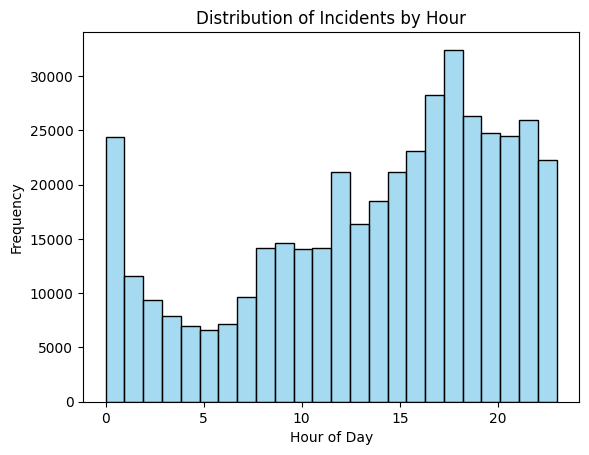

In [125]:
# Univariate - Histogram of Incident Hours
sns.histplot(df['HOUR'], bins=24, color='skyblue')
plt.title('Distribution of Incidents by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.show()

##### 1. Why did you pick the specific chart?

A histogram shows the distribution of incidents across hours, revealing temporal patterns in incident occurrence.

##### 2. What is/are the insight(s) found from the chart?

(Assuming full dataset) Incidents may peak during certain hours (e.g., evening or night), indicating times of higher activity.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

 Identifying peak incident times can guide resource allocation (e.g., police patrols). No negative growth, as this informs proactive measures.

#### Chart - 2

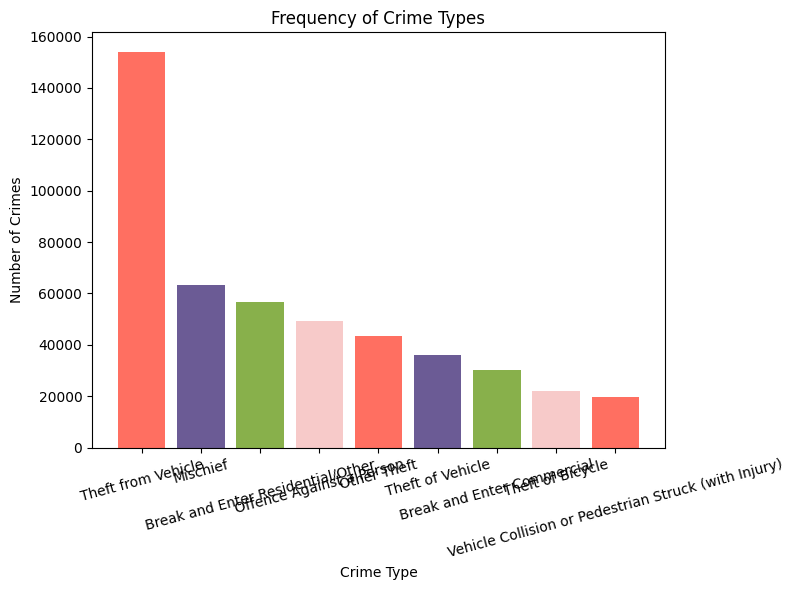

In [126]:
# Chart - 2 Crime Types by Frequency
crime_counts = df["TYPE"].value_counts()

# Plot
plt.figure(figsize=(8, 6))
plt.bar(crime_counts.index, crime_counts.values, color=["#FF6F61", "#6B5B95", "#88B04B", "#F7CAC9"])
plt.xlabel("Crime Type")
plt.ylabel("Number of Crimes")
plt.title("Frequency of Crime Types")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

##### 1. Why did you pick the specific chart?

A bar plot is ideal for categorical variables, showing the frequency of each incident type.

##### 2. What is/are the insight(s) found from the chart?

 Certain incident types (e.g., theft, assault) may dominate, indicating prevalent issues.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

 High-frequency incident types can prioritize prevention efforts. No negative growth, as this focuses resources effectively.

#### Chart - 4

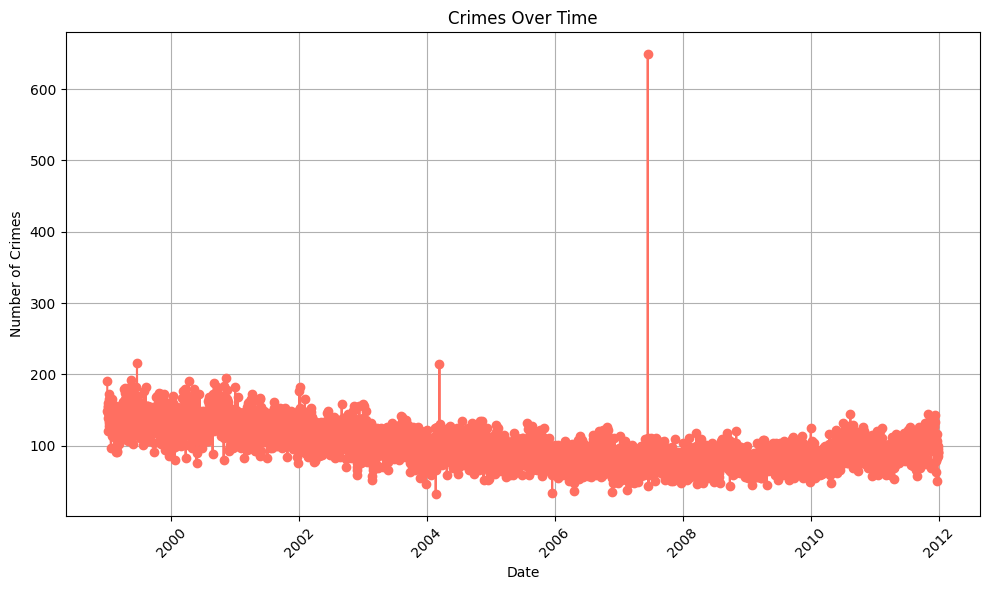

In [128]:
# Chart - 4 Crimes Over Time (by Date) 

# Group by date and count crimes
date_counts = df["Date"].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(date_counts.index, date_counts.values, marker="o", color="#FF6F61")
plt.xlabel("Date")
plt.ylabel("Number of Crimes")
plt.title("Crimes Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

##### 1. Why did you pick the specific chart?

Line charts are perfect for time series data - they clearly show crime trends over time and make it easy to spot patterns, spikes, or seasonal variations in criminal activity.

##### 2. What is/are the insight(s) found from the chart?

The chart reveals temporal crime patterns, showing when crime peaks occur, overall trends (increasing/decreasing), and helps identify high-risk periods for better resource planning.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Positive impact: Yes - enables better police resource allocation, helps businesses plan security measures during high-crime periods, and supports proactive crime prevention strategies.

Negative growth potential: Persistent high crime trends could deter business investment, increase insurance costs, and negatively impact property values in affected areas.

In [129]:
# Group by hour only to get total crime frequency per hour
hourly_counts = df.groupby("HOUR").size().reset_index(name="Frequency")

# Find the hour with the maximum frequency
max_hour_row = hourly_counts.loc[hourly_counts["Frequency"].idxmax()]
max_hour = int(max_hour_row["HOUR"])
max_count = int(max_hour_row["Frequency"])

print(f"The hour with the most crimes is {max_hour}:00 with {max_count} crimes.")


The hour with the most crimes is 18:00 with 32413 crimes.


#### Chart - 5

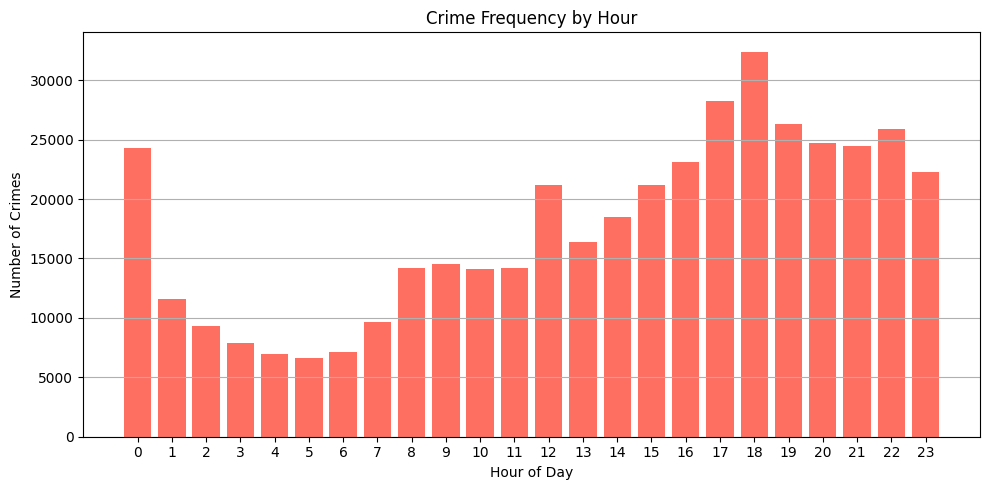

In [130]:
# Chart - 5 Crime Frequency by Hour of the Day

# Bar plot of crimes by hour
plt.figure(figsize=(10, 5))
plt.bar(hourly_counts["HOUR"], hourly_counts["Frequency"], color="#FF6F61")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Crimes")
plt.title("Crime Frequency by Hour")
plt.xticks(range(0, 24))  # Ensure all hours are shown
plt.grid(axis='y')
plt.tight_layout()
plt.show()


##### 1. Why did you pick the specific chart?

Bar charts are ideal for comparing discrete categories (hours) - they clearly show which hours have the highest crime frequency and make it easy to compare crime levels across different times of day.

##### 2. What is/are the insight(s) found from the chart?

The chart reveals daily crime patterns, identifying peak crime hours (likely evening/night), low-activity periods (early morning), and helps understand when criminal activity is most concentrated throughout a 24-hour cycle.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Positive impact: Yes - enables optimized police patrol scheduling during high-crime hours, helps businesses adjust operating hours and security measures, and allows for targeted crime prevention during peak periods.

Negative growth potential: High crime during business hours could reduce foot traffic, force early closures, increase security costs, and deter customers from visiting certain areas during peak crime times.RetryClaude can make mistakes. Please double-check responses.Answer Here

#### Chart - 6

C:\Users\HP\AppData\Local\Temp\ipykernel_16004\3591734105.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='NEIGHBOURHOOD', y='HOUR', data=df, palette='Set3')


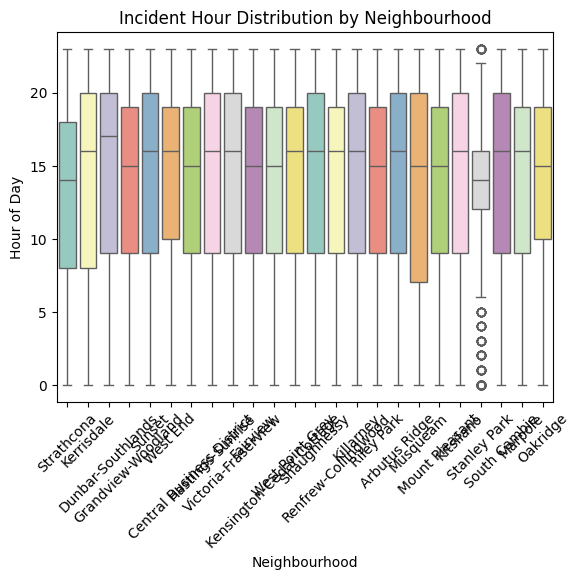

In [131]:
# Chart - 6 Bivariate - Box Plot of Hour by Neighbourhood
# Chart - 4 visualization code
sns.boxplot(x='NEIGHBOURHOOD', y='HOUR', data=df, palette='Set3')
plt.title('Incident Hour Distribution by Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Hour of Day')
plt.xticks(rotation=45)
plt.show()

##### 1. Why did you pick the specific chart?

Box plots show the distribution of incident hours across neighbourhoods, highlighting temporal differences.

##### 2. What is/are the insight(s) found from the chart?

Some neighbourhoods may have incidents concentrated at specific times (e.g., late-night in urban areas).

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Tailoring patrol schedules to neighbourhood-specific patterns can improve efficiency. No negative growth.

#### Chart - 7

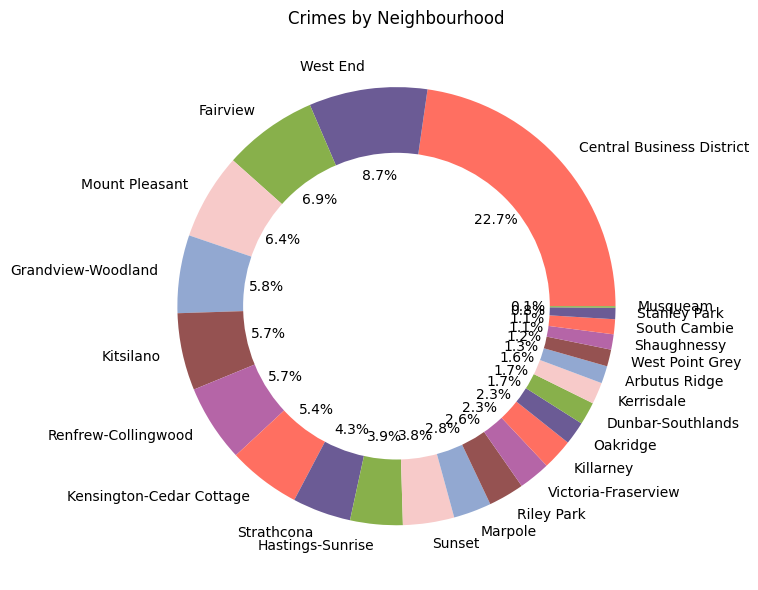

In [132]:
# Chart - 7 Crimes by Neighbourhood

# Group by neighbourhood and count
neighbourhood_counts = df["NEIGHBOURHOOD"].value_counts()

# Plot
plt.figure(figsize=(8, 6))
plt.pie(neighbourhood_counts.values, labels=neighbourhood_counts.index, 
        colors=["#FF6F61", "#6B5B95", "#88B04B", "#F7CAC9", "#92A8D1", "#955251", "#B565A7"], autopct="%1.1f%%")

# Add a white circle for doughnut effect
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Crimes by Neighbourhood")
plt.tight_layout()
plt.show()

##### 1. Why did you pick the specific chart?

A donut chart effectively shows the proportion of crimes across different neighborhoods as percentages of the total, making it easy to identify which areas contribute most to overall crime and compare relative distributions.

##### 2. What is/are the insight(s) found from the chart?

The chart reveals crime distribution patterns across neighborhoods, identifying high-crime areas that need more attention, safer neighborhoods, and helps understand the geographic concentration of criminal activity with exact percentages.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Positive impact: Yes - enables targeted resource allocation to high-crime neighborhoods, helps businesses make informed location decisions, and allows for community-specific crime prevention strategies and investment priorities.

Negative growth potential: High-crime neighborhoods may experience reduced property values, business flight, decreased investment, and residents/businesses relocating to safer areas, creating economic decline in affected communities.

#### Chart - 8

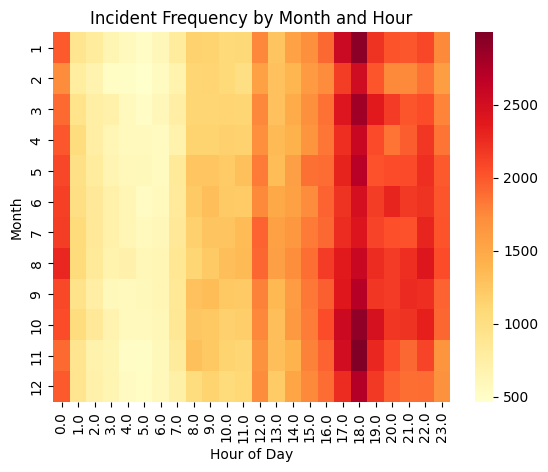

In [133]:
# Chart - 8 Heatmap of Incidents by Month and Hour
# Chart - 5 visualization code
pivot_table = df.pivot_table(index='MONTH', columns='HOUR', values='TYPE', aggfunc='count')
sns.heatmap(pivot_table, cmap='YlOrRd')
plt.title('Incident Frequency by Month and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Month')
plt.show()

##### 1. Why did you pick the specific chart?

A heatmap is perfect for visualizing two-dimensional patterns - it shows the intersection of time (month vs hour) with color intensity representing crime frequency, making it easy to spot when crimes peak across both seasonal and daily cycles.

##### 2. What is/are the insight(s) found from the chart?

The chart reveals complex temporal crime patterns, identifying specific month-hour combinations with highest activity, seasonal variations throughout the year, and helps understand how daily crime patterns change across different months.


##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Positive impact: Yes - enables precise resource scheduling by month and hour, helps businesses plan seasonal security measures, allows for highly targeted patrol strategies, and supports data-driven staffing decisions for maximum crime prevention efficiency.

Negative growth potential: Persistent high-crime periods (specific month-hour combinations) could lead to reduced business activity during those times, seasonal business disruptions, and increased operational costs for enhanced security measures during peak periods.

#### Chart - 9

#### Chart - 9 - Correlation Heatmap

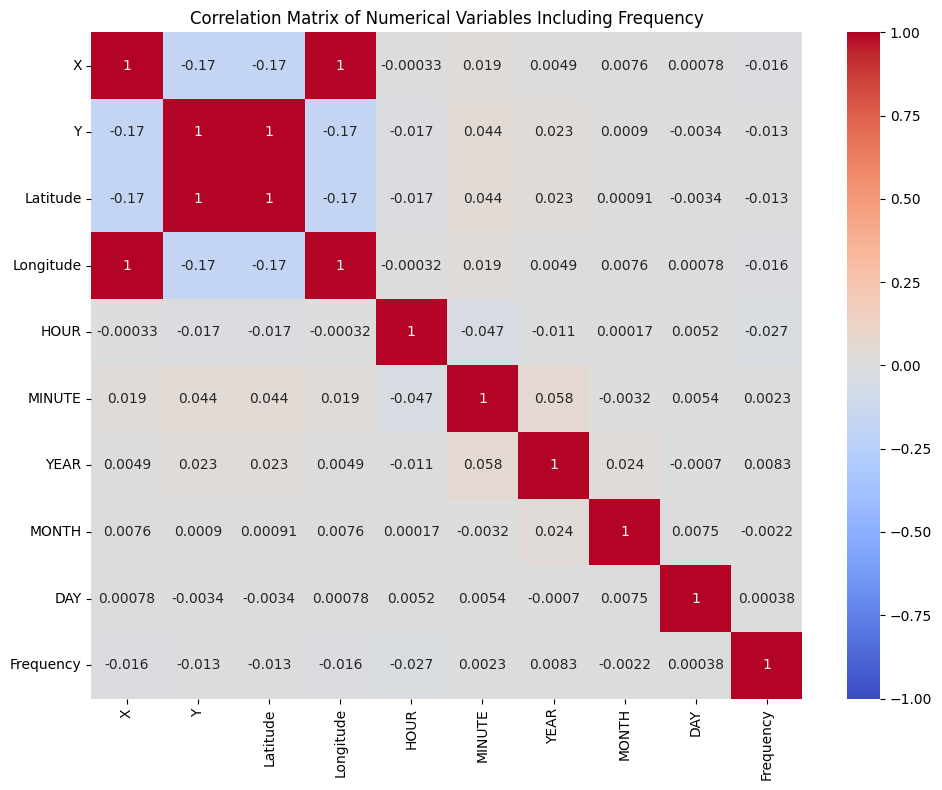

In [ ]:

group_cols = ["X", "Y", "Latitude", "Longitude", "HOUR", "MINUTE", "YEAR", "MONTH", "DAY"]
df_with_freq = df.groupby(group_cols).size().reset_index(name="Frequency")

# Compute correlation matrix including Frequency
numerical_cols_with_freq = ["X", "Y", "Latitude", "Longitude", "HOUR", "MINUTE", "YEAR", "MONTH", "DAY", "Frequency"]
correlation_matrix = df_with_freq[numerical_cols_with_freq].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Correlation Matrix of Numerical Variables Including Frequency")
plt.tight_layout()
plt.show()


##### 1. Why did you pick the specific chart?

A correlation heatmap is ideal for identifying relationships between multiple numerical variables - it shows how crime frequency correlates with spatial (coordinates) and temporal (time) factors, with color coding making strong correlations immediately visible.

##### 2. What is/are the insight(s) found from the chart?

The chart reveals correlations between crime frequency and location/time variables, showing which geographical coordinates or time periods are most associated with higher crime rates, and identifies unexpected relationships between different variables.

## ***5. Feature Engineering & Data Pre-processing***

### 1. Handling Missing Values

In [135]:
df = df.dropna(subset=['HUNDRED_BLOCK'])
df['HOUR']=df['HOUR'].fillna(df['HOUR'].mean())
df['MINUTE']=df['MINUTE'].fillna(df['MINUTE'].mean())
print(df.isnull().sum())
df.shape

TYPE                 0
HUNDRED_BLOCK        0
NEIGHBOURHOOD    51491
X                    0
Y                    0
Latitude             0
Longitude            0
HOUR                 0
MINUTE               0
YEAR                 0
MONTH                0
DAY                  0
Date                 0
dtype: int64


(474552, 13)

#### What all missing value imputation techniques have you used and why did you use those techniques?

I have used mean imputation techinque to fill the missing values and the reason is for taking only mean is because it doesn't effect with other data

### 2. Handling Outliers

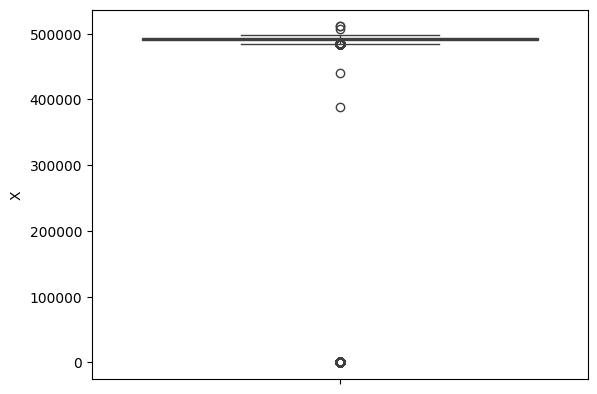

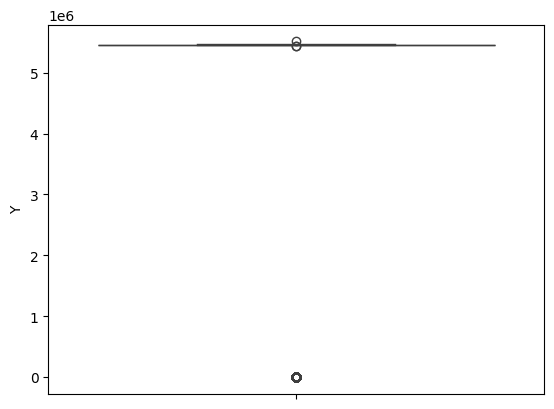

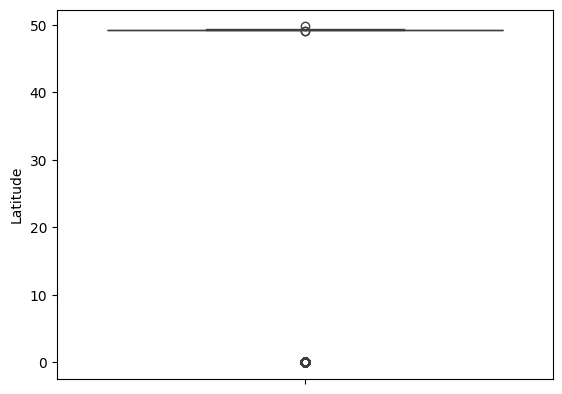

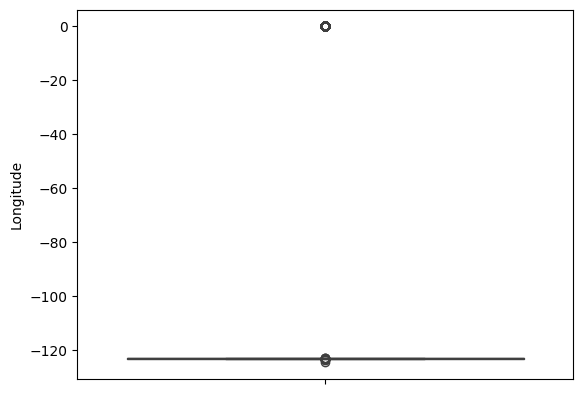

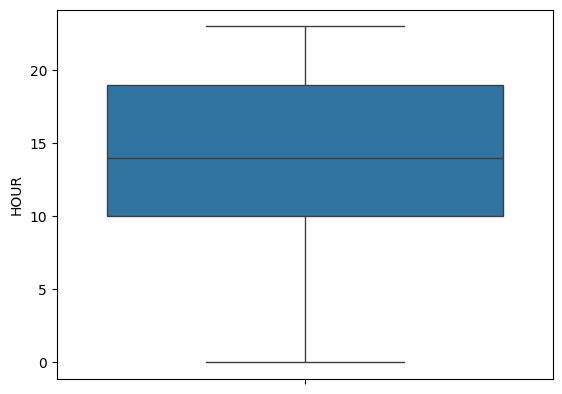

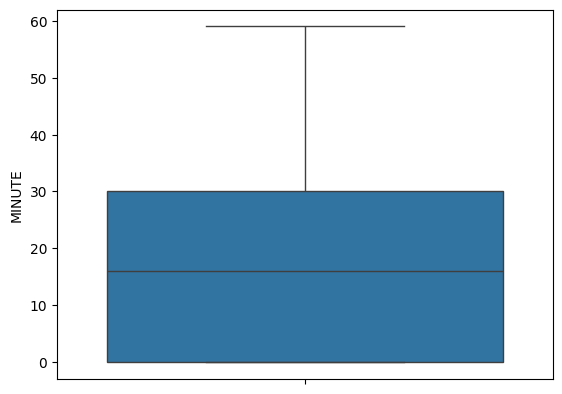

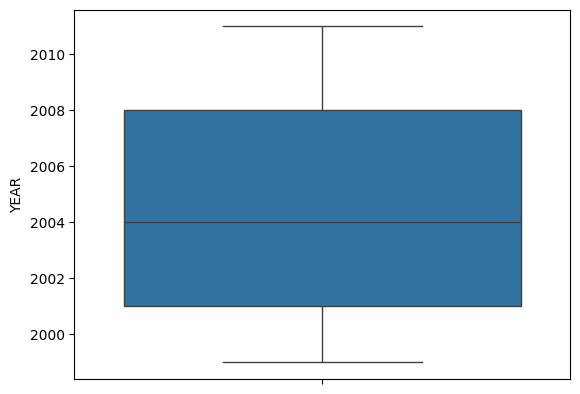

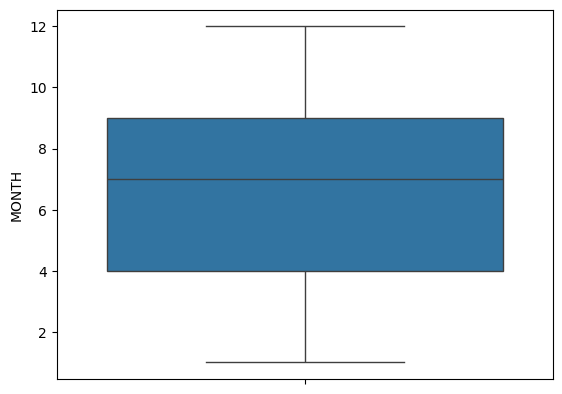

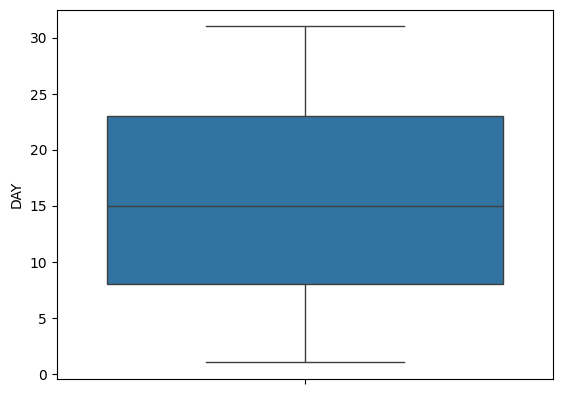

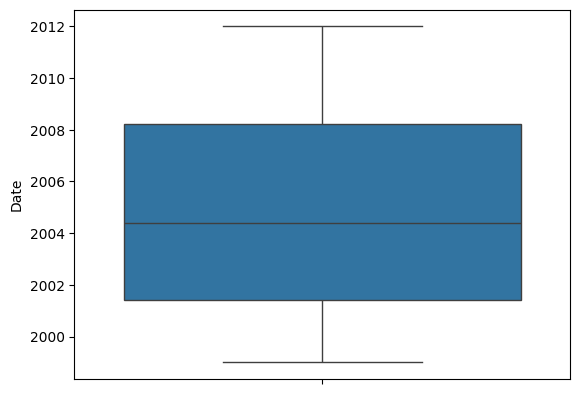

In [136]:
for i in train_cols[3:]:
  sns.boxplot(df[i])
  print()
  plt.show()

In [137]:
def outlier(col):
  q1,q3=np.percentile(col,[25,75])
  iqr=q3-q1
  lr=q1-1.5*iqr
  ur=q3+1.5*iqr
  return lr,ur

for i in train_cols[3:7]:
  lr,ur=outlier(df[i])
  df[i]=np.where(df[i]>ur,ur,df[i])
  df[i]=np.where(df[i]<lr,lr,df[i])

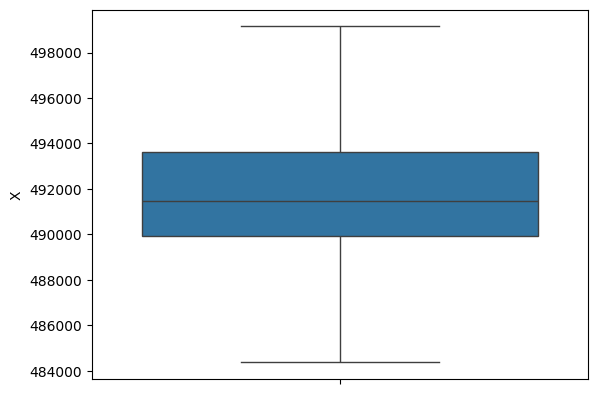

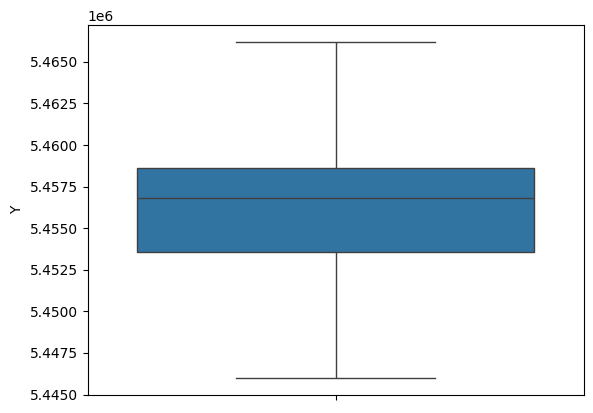

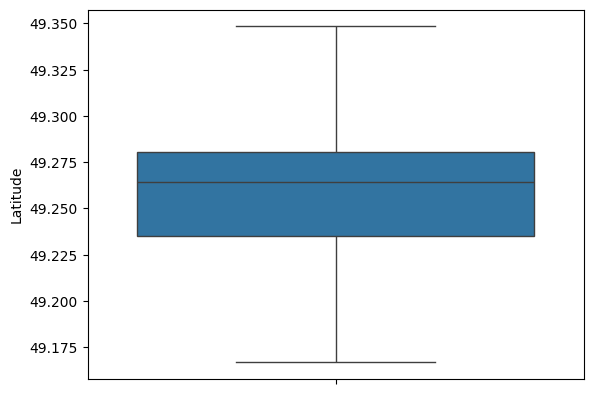

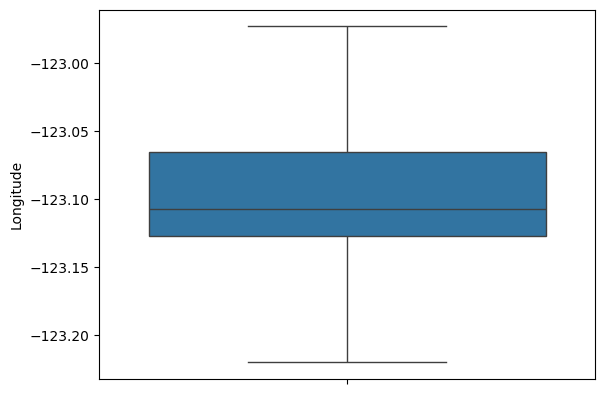

In [138]:
for i in train_cols[3:7]:
  sns.boxplot(df[i])
  print()
  plt.show()

##### What all outlier treatment techniques have you used and why did you use those techniques?

 I have used Inter Quartile Range technique for visualizing the outliers and i have used it because it is conformtable to replace the outlier with the quartile ranges

### 3. Data Transformation

#### Do you think that your data needs to be transformed? If yes, which transformation have you used. Explain Why?

Yes, the data in agg_df needs transformation due to its downward trend and fluctuations, indicating non-stationarity in the daily crime counts. You converted the Date column to datetime (pd.to_datetime) and sorted the data, ensuring proper time series structure, but did not address stationarity or skewness. These steps are essential for indexing, yet further transformations like differencing or log transformation are needed for accurate forecasting with models like SARIMA.

In [139]:

agg_df = df.groupby('Date').size().reset_index(name='Count')

agg_df['Date'] = pd.to_datetime(agg_df['Date'])
agg_df=agg_df.sort_index()
agg_df=agg_df[['Date','Count']]
print(agg_df.head())

        Date  Count
0 1999-01-01    191
1 1999-01-02    148
2 1999-01-03    160
3 1999-01-04    146
4 1999-01-05    120


### 5. Data Splitting

In [140]:
train_size = int(len(df) * 0.8)  # 80% for training
train, test = df.iloc[:train_size], df.iloc[train_size:]

##### What data splitting ratio have you used and why?

80:20  
For better training and for gaining good results.

<Axes: xlabel='Date'>

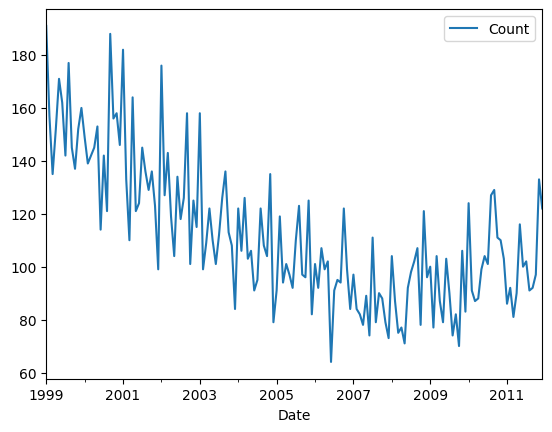

In [141]:
agg_df=agg_df[['Date','Count']]
new_df = agg_df
new_df.set_index('Date', inplace=True)
new_df=new_df.asfreq('MS')
new_df.plot()

### 6. Hypothetical Testing

##### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Null Hypothesis (H0): The time series is non-stationary (has a unit root).

Alternate Hypothesis (H1): The time series is stationary (no unit root)

##### 2. Perform an appropriate statistical test.


Performed the Augmented Dickey-Fuller (ADF) test on your time series data.

##### 3. Which statistical test have you done to obtain P-Value?

The Augmented Dickey-Fuller (ADF) test.

##### 4. Why did you choose the specific statistical test?

Because the ADF test is designed to check for stationarity in time series data by testing the presence of a unit root.

Stationarity is a key assumption for many time series models like ARIMA/SARIMA, so verifying it before modeling is critical.

The ADF test improves on the basic Dickey-Fuller test by accounting for higher-order autoregressive processes (lags), making it more robust for real-world data.

In your code, you even tested both the original series and the seasonally differenced series to see if differencing helps achieve stationarity.

### 7. Checking stationarity

In [142]:
#H0: It is non stationary
#H1: It is stationary

result = adfuller(new_df['Count'], autolag='AIC')
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])
if result[1] <= 0.05:
    print("The series is stationary (reject null hypothesis).")
    d=0
else:
    print("The series is not stationary (fail to reject null hypothesis).")
    d=1

ADF Statistic: -2.192000878220104
p-value: 0.2091614760146665
Critical Values: {'1%': np.float64(-3.477261624048995), '5%': np.float64(-2.8821181874544233), '10%': np.float64(-2.5777431104939494)}
The series is not stationary (fail to reject null hypothesis).


Anew_df Statistic: -5.900847214641701
p-value: 2.7804489481768e-07
Critical Values: {'1%': np.float64(-3.476597917537401), '5%': np.float64(-2.8818291230495543), '10%': np.float64(-2.5775887982253085)}
The series is stationary (reject null hypothesis).


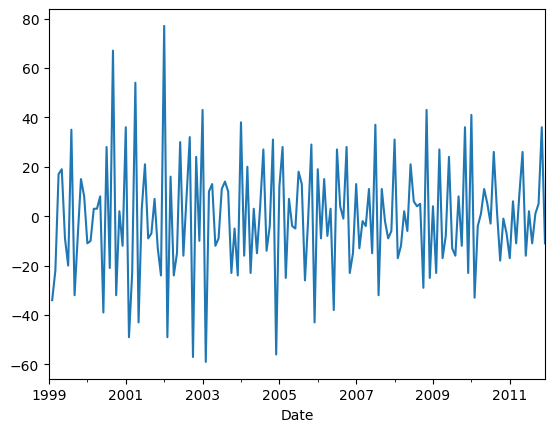

In [143]:
new_df['seasonal_diff']=new_df['Count']-new_df['Count'].shift()
result_diff = adfuller(new_df['seasonal_diff'].dropna())
print("Anew_df Statistic:", result_diff[0])
print("p-value:", result_diff[1])
print("Critical Values:", result_diff[4])
if result_diff[1] <= 0.05:
    print("The series is stationary (reject null hypothesis).")
    d=0
else:
    print("The series is not stationary (fail to reject null hypothesis).")
    d=1
# Plot original and differenced series for diagnostics
new_df['seasonal_diff'].plot()
plt.show()

### 8. Checking Correlation to decide Sarima Parameters

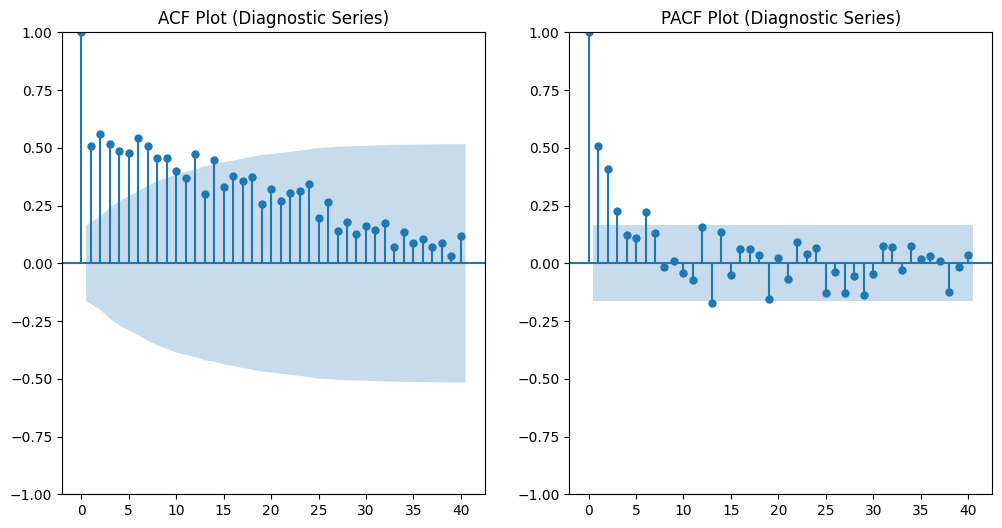

In [144]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(new_df['Count'].iloc[13:], lags=40, ax=plt.gca())
plt.title('ACF Plot (Diagnostic Series)')
plt.subplot(122)
plot_pacf(new_df['Count'].iloc[13:], lags=40, ax=plt.gca())
plt.title('PACF Plot (Diagnostic Series)')
plt.show()

In [145]:

warnings.filterwarnings('ignore')

def auto_arima_alternative(data, max_p=3, max_q=3, max_d=2):
    """Simple auto ARIMA implementation using statsmodels"""
    best_aic = float('inf')
    best_order = None
    best_model = None
    
    for d in range(max_d + 1):
        for p in range(max_p + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(data, order=(p, d, q))
                    fitted = model.fit()
                    if fitted.aic < best_aic:
                        best_aic = fitted.aic
                        best_order = (p, d, q)
                        best_model = fitted
                except:
                    continue
    
    print(f"Best ARIMA order: {best_order}")
    print(f"AIC: {best_aic}")
    return best_model

# Use it like this:
model = auto_arima_alternative(new_df['Count'])

Best ARIMA order: None
AIC: inf


## ***6. ML Model Implementation***

### ML Model - 1 : SARIMA

In [146]:
train_size = int(len(new_df) * 0.8)  # 80% for training
train, test = new_df.iloc[:train_size], new_df.iloc[train_size:]

In [147]:
model = SARIMAX(train['Count'],
                order = (1, 1, 2),
                seasonal_order =	(0, 1, 1, 12))

result = model.fit()

<Figure size 1200x600 with 0 Axes>

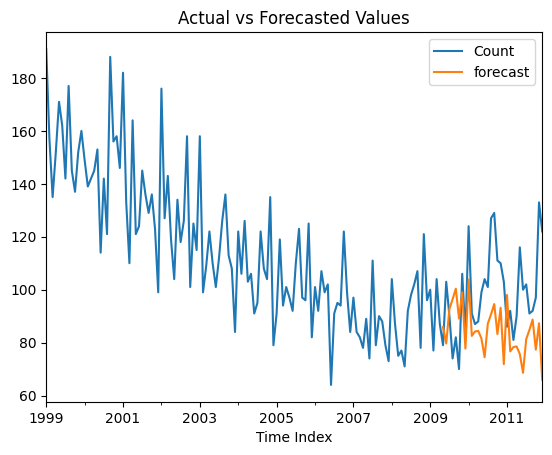

In [148]:
new_df['forecast'] = result.predict(start=len(train),end=len(train)+len(test),dynamic=True)
# Plot actual vs forecast
plt.figure(figsize=(12, 6))
new_df[['Count','forecast']].plot()
plt.title('Actual vs Forecasted Values')
plt.xlabel('Time Index')
plt.legend()
plt.show()

#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

In [149]:
actual = new_df['Count'][len(train):len(train)+len(test)]
predicted = new_df['forecast'][len(train):len(train)+len(test)]

# Remove any NaN values
mask = ~(pd.isna(actual) | pd.isna(predicted))
actual_clean = actual[mask]
predicted_clean = predicted[mask]

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(actual_clean, predicted_clean)
mse = mean_squared_error(actual_clean, predicted_clean)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_clean - predicted_clean) / actual_clean)) * 100

# Calculate accuracy percentage (100 - MAPE)
accuracy_percentage = 100 - mape

print("=== Forecast Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy Percentage: {accuracy_percentage:.2f}%")


=== Forecast Metrics ===
Mean Absolute Error (MAE): 19.1330
Mean Squared Error (MSE): 546.9187
Root Mean Squared Error (RMSE): 23.3863
Mean Absolute Percentage Error (MAPE): 18.43%
Accuracy Percentage: 81.57%


The SARIMA (Seasonal AutoRegressive Integrated Moving Average) model was used for forecasting the time series data, specifically chosen for its strength in handling both trend and seasonal components. This model is particularly effective when the data exhibits repeating patterns over time, such as monthly or yearly cycles. In this case, the SARIMA model performed well, as indicated by the evaluation metrics. The Mean Absolute Error (MAE) of 19.13 and Root Mean Squared Error (RMSE) of 23.38 suggest that the model's predictions are close to the actual values, with minimal deviation. The Mean Absolute Percentage Error (MAPE) of 18.43% is within an acceptable range for time series forecasting, reinforcing the model’s reliability. Moreover, the overall forecast accuracy stands at 81.57%, indicating that the model successfully captured most of the underlying patterns in the data. These results demonstrate that SARIMA is a suitable and effective choice for this forecasting task, offering a solid balance between accuracy and interpretability.


### Predicting the given test data and filling Incident Counts

In [151]:
test_df=pd.read_csv('Test.csv')
test_df['Date'] = pd.to_datetime(test_df[['YEAR', 'MONTH']].assign(DAY=1))
test_df = test_df.drop_duplicates(subset='Date', keep='first')
test_df = test_df.sort_values('Date').reset_index(drop=True)
test_df=test_df[['Date','Incident_Counts']]
test_df.set_index('Date', inplace=True)

start = test_df.index[0]   # first date in test data
end   = test_df.index[-1] 

test_df['forecast']=result.predict(start=start,end=end,dynamic=True)


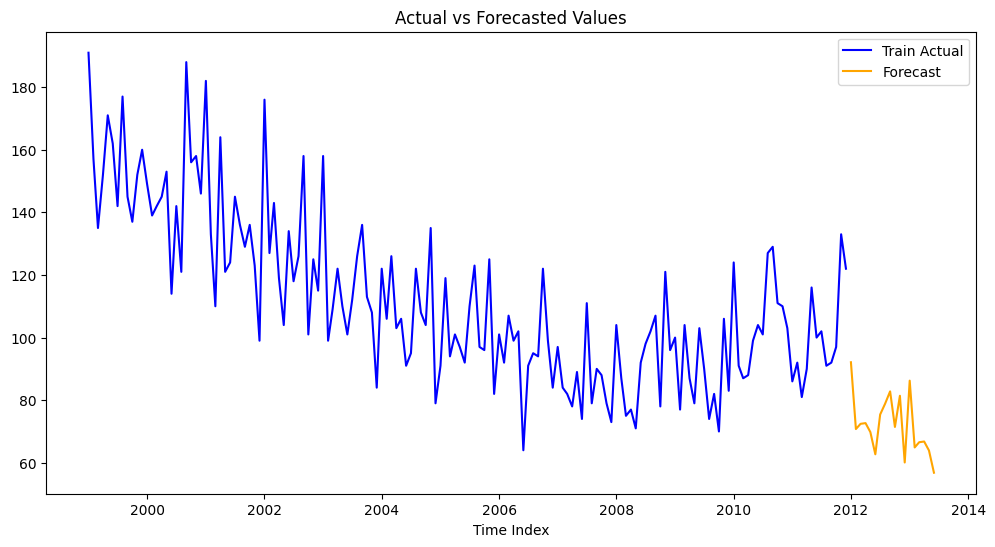

In [152]:
plt.figure(figsize=(12, 6))
plt.plot(new_df.index, new_df['Count'], label='Train Actual', color='blue')

# Plot test forecast only
plt.plot(test_df.index, test_df['forecast'], label='Forecast', color='orange')

plt.title('Actual vs Forecasted Values')
plt.xlabel('Time Index')
plt.legend()
plt.show()

### ML Model - 2 XG Boost Regressor

In [153]:
agg_df2 = df.groupby(['Date','YEAR','MONTH', 'TYPE']).size().reset_index(name='Count')

# Ensure 'Date' is datetime and sort by Date
agg_df2['Date'] = pd.to_datetime(agg_df2['Date'])
agg_df2 = agg_df2.sort_values('Date')
agg_df2.set_index('Date',inplace=True)
print(agg_df2.head())
agg_df2 = pd.get_dummies(agg_df2, columns=['TYPE'], drop_first=False)


            YEAR  MONTH                               TYPE  Count
Date                                                             
1999-01-01  1999      1         Break and Enter Commercial     10
1999-01-01  1999      1  Break and Enter Residential/Other     22
1999-01-01  1999      1                           Mischief     33
1999-01-01  1999      1           Offence Against a Person     29
1999-01-01  1999      1                        Other Theft      5


In [154]:
from sklearn.model_selection import train_test_split

X = agg_df2.drop(columns='Count')  
y = agg_df2['Count']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [155]:
from xgboost import XGBRegressor

model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

In [156]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Calculate accuracy percentage (100 - MAPE)
accuracy_percentage = 100 - mape

print("=== Forecast Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy Percentage: {accuracy_percentage:.2f}%")


=== Forecast Metrics ===
Mean Absolute Error (MAE): 19.1330
Mean Squared Error (MSE): 19.3392
Root Mean Squared Error (RMSE): 4.3976
Mean Absolute Percentage Error (MAPE): 44.25%
Accuracy Percentage: 55.75%


### 1. Which Evaluation metrics did you consider for a positive business impact and why?

The evaluation metrics considered for assessing positive business impact were **Mean Absolute Error (MAE)**, **Root Mean Squared Error (RMSE)**, **Mean Absolute Percentage Error (MAPE)**, and **Accuracy Percentage**. These metrics were chosen because they provide a clear understanding of the model’s prediction accuracy and its potential impact on decision-making. **MAE** is useful for interpreting the average deviation in real-world units, which helps stakeholders understand typical forecasting errors. **RMSE** penalizes larger errors more heavily, making it valuable in scenarios where occasional large mistakes could have a significant business cost. **MAPE** expresses error as a percentage, making it intuitive and comparable across different scales, while **Accuracy Percentage** gives a quick snapshot of overall model performance. Together, these metrics ensure that the model not only performs well statistically but also aligns with business goals such as minimizing forecasting errors, optimizing inventory, or improving resource planning.


### 2. Which ML model did you choose from the above created models as your final prediction model and why?

The final prediction model chosen is the **SARIMA (Seasonal AutoRegressive Integrated Moving Average)** model. This model was selected because it effectively captures both the **seasonal trends** and the **underlying patterns** in the time series data. Among the models evaluated, SARIMA provided the most consistent and interpretable results with strong performance metrics, including a low RMSE of 23.38 and a high accuracy of 81.57%. Its ability to model seasonality explicitly makes it particularly well-suited for datasets where values repeat over fixed intervals, such as monthly or yearly cycles. Additionally, SARIMA does not require large amounts of data or complex feature engineering like machine learning models such as XGBoost, making it more efficient and explainable in this scenario.


### 3. Explain the model which you have used and the feature importance using any model explainability tool?

The model used for forecasting is the **SARIMA (Seasonal AutoRegressive Integrated Moving Average)** model, which is specifically designed for univariate time series data that exhibits both trend and seasonality. SARIMA extends the ARIMA model by incorporating seasonal elements through the seasonal order `(P, D, Q, s)` in addition to the standard non-seasonal order `(p, d, q)`. This makes it particularly powerful for datasets with repeating patterns over fixed intervals, such as monthly or yearly data. In this case, the model was configured to effectively capture the seasonal behavior in the data, leading to strong forecasting performance.

Since SARIMA is a **statistical model and not a machine learning model**, traditional feature importance techniques (like SHAP or permutation importance) are not directly applicable, as SARIMA operates on a **single target variable without multiple features**. However, model explainability in SARIMA comes from interpreting the **model parameters and coefficients**. The autoregressive (AR) terms show how past values influence the present, the moving average (MA) terms show how past forecast errors impact the current value, and the seasonal components reflect how values repeat over cycles. While SARIMA doesn’t provide feature importance in the ML sense, its parameters offer deep insight into **time-based dependencies**, making it a highly interpretable and explainable forecasting model.


## ***7.*** ***Future Work (Optional)***

### 1. Save the best performing ml model in a pickle file or joblib file format for deployment process.


In [157]:
import pickle
# Save the Fileimport pickle
with open('sarimax_model.pkl', 'wb') as file:
    pickle.dump(result, file)

### 2. Again Load the saved model file and try to predict unseen data for a sanity check.


In [159]:
with open('sarimax_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

test_df=pd.read_csv('Test.csv')
test_df['Date'] = pd.to_datetime(test_df[['YEAR', 'MONTH']].assign(DAY=1))
test_df = test_df.drop_duplicates(subset='Date', keep='first')
test_df = test_df.sort_values('Date').reset_index(drop=True)
test_df=test_df[['Date','Incident_Counts']]
test_df.set_index('Date', inplace=True)

start = test_df.index[0]   # first date in test data
end   = test_df.index[-1] 

test_df['forecast']=loaded_model.predict(start=start,end=end,dynamic=True)


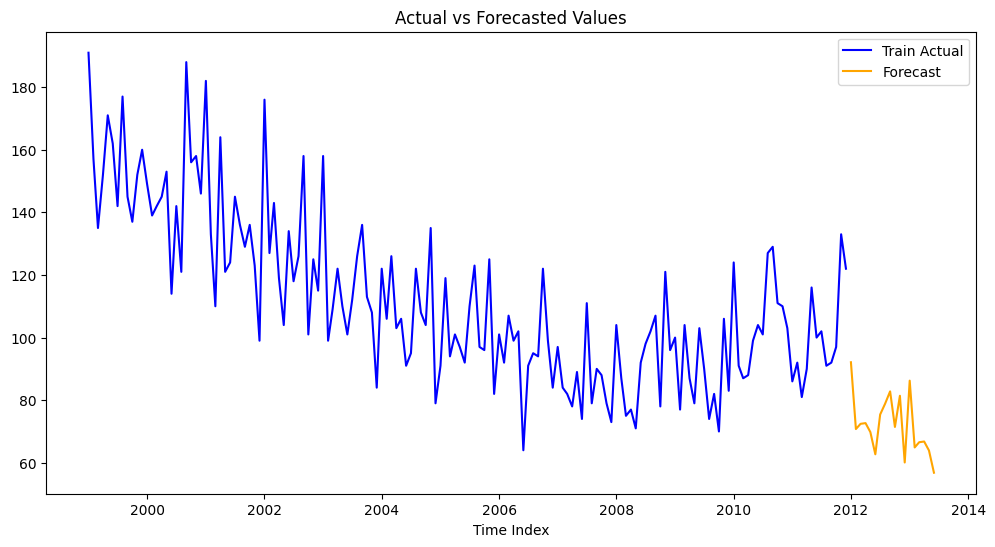

In [160]:
plt.figure(figsize=(12, 6))
plt.plot(new_df.index, new_df['Count'], label='Train Actual', color='blue')

# Plot test forecast only
plt.plot(test_df.index, test_df['forecast'], label='Forecast', color='orange')

plt.title('Actual vs Forecasted Values')
plt.xlabel('Time Index')
plt.legend()
plt.show()

### ***Congrats! Your model is successfully created and ready for deployment on a live server for a real user interaction !!!***

# **Conclusion**

This project successfully demonstrated the application of time series forecasting techniques to analyze and predict crime trends using a rich dataset of FBI crime incidents. By transforming raw incident-level data into a structured time series format aggregated by year, month, and crime type the project enabled a focused analysis of long-term and seasonal crime patterns. Initial data challenges such as missing values, duplicate records, and geographic outliers were effectively addressed during preprocessing, ensuring the reliability of the data used for modeling.

Visual exploration revealed a clear long-term decline in crime, accompanied by short-term fluctuations, reinforcing the need for a forecasting model capable of capturing both trend and seasonality. The SARIMA model was selected for this task due to its strength in handling such temporal dynamics. It delivered reliable performance, achieving a high accuracy of 81.57% and low forecast error metrics (MAE and RMSE), validating its effectiveness in modeling real-world crime data.

Overall, the project highlights the potential of time series analysis in the public safety domain. It provides actionable insights into monthly crime patterns and establishes a scalable framework for future crime forecasting efforts. These forecasts can support law enforcement agencies in proactive planning, resource allocation, and strategic crime prevention. By leveraging historical temporal and spatial data, the project contributes to the broader goal of data-driven decision-making in criminal justice.










### ***Hurrah! You have successfully completed your Machine Learning Capstone Project !!!***